**Author: Carlos Alberto C. da Purificação**

Contact me at: geofisico2007@gmail.com or carlos.purificacao@fbter.org.br

# Fine tuning CNN hyperparameters

This notebook was created to help data scientists perform fine tuning in convolution neural networks, such as number of filters in the Convolution layer, number of neurons in the Dense layer and also, to obtain the best hyperparameters for the optimizer (Adam, SGD, etc.),  such as learning rate, decay rate, etc.

In [10]:
import time
import os
import numpy as np
import IPython

from kerastuner.tuners import (
    BayesianOptimization,
    Hyperband,
    RandomSearch,
)

from loguru import logger
from pathlib import Path
import tensorflow as tf
from hypermodels import SearchModel
from utils import load_data
import matplotlib.pyplot as plt

In [ ]:
# asigning values to the constants (variables that won't change during the execution of this .ipynb)
SEED = 1
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)

N_EPOCH_SEARCH = 15
HYPERBAND_MAX_EPOCHS = 40
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2
BAYESIAN_NUM_INITIAL_POINTS = 1

# Showing a small sample withing the MNIST dataset

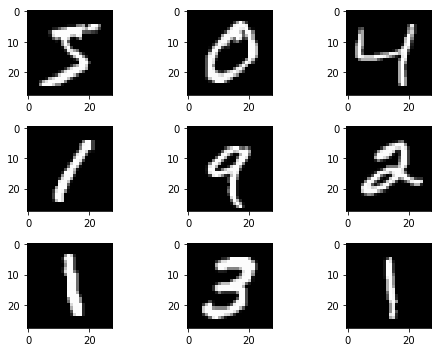

In [2]:
#Load the data
x_test, x_train, y_test, y_train = load_data()

plt.figure(figsize=(7,5))

for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(np.squeeze(x_train)[i], cmap=plt.get_cmap('gray'))
plt.tight_layout()
plt.show()

In [3]:
# setting up as much GPUs as you please/have in your machine/server.
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [4]:
#function to instantiate the tuner classes (here, we are making a comparition between the three available 
#keras-tuner classes: RandomSearch, Hyperband and BayesianOptimization).
def tuners_choice(hypermodel, directory, project_name):
    random_tuner = RandomSearch(
        hypermodel,
        objective="val_accuracy",
        seed=SEED,
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTION_PER_TRIAL,
        directory=f"{directory}_random_search",
        project_name=project_name,
        distribution_strategy=tf.distribute.MirroredStrategy(),
    )
    hyperband_tuner = Hyperband(
        hypermodel,
        max_epochs=HYPERBAND_MAX_EPOCHS,
        objective="val_accuracy",
        seed=SEED,
        executions_per_trial=EXECUTION_PER_TRIAL,
        directory=f"{directory}_hyperband",
        project_name=project_name,
        distribution_strategy=tf.distribute.MirroredStrategy(),
    )
    bayesian_tuner = BayesianOptimization(
        hypermodel,
        objective='val_accuracy',
        seed=SEED,
        num_initial_points=BAYESIAN_NUM_INITIAL_POINTS,
        max_trials=MAX_TRIALS,
        directory=f"{directory}_bayesian",
        project_name=project_name,
        distribution_strategy=tf.distribute.MirroredStrategy(),

    )
    return  [random_tuner, hyperband_tuner, bayesian_tuner]

In [5]:
# Class to be used as callback to clear the IPython notebook session
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [6]:
def tuner_evaluation(tuner, x_test, x_train, y_test, y_train):

    tuner.search_space_summary()

    # Performs the hyperparameter tuning
    logger.info("Start hyperparameter tuning")
    search_start = time.time()
    tuner.search(x_train, y_train, epochs=N_EPOCH_SEARCH, validation_split=0.2, callbacks = [ClearTrainingOutput()])

    search_end = time.time()
    elapsed_time = search_end - search_start

    # Show a summary of the search
    tuner.results_summary()

    # Retrieve the best model.
    best_model = tuner.get_best_models(num_models=1)[0]

    # Evaluate the best model.
    loss, accuracy = best_model.evaluate(x_test, y_test)
    return elapsed_time, loss, accuracy

In [7]:
# with strategy.scope():
x_test, x_train, y_test, y_train = load_data()
hypermodel = SearchModel(shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
output_dir = Path("./output/")
tuners = tuners_choice(hypermodel, directory=output_dir, project_name="cnn_tuning")

results = []
for tuner in tuners:
    elapsed_time, loss, accuracy = tuner_evaluation(
        tuner, x_test, x_train, y_test, y_train
    )
    logger.info(
        f"Elapsed time = {elapsed_time:10.4f} s, accuracy = {accuracy}, loss = {loss}"
    )
    results.append([elapsed_time, loss, accuracy])
    
logger.info(results)

INFO:tensorflow:Oracle triggered exit


313/313 [==============================] - ETA: 0s - loss: 8.9482e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0195 - accuracy: 0.9935   - ETA: 0s - loss: 0.0386 - accuracy: 0.98 - ETA: 0s - loss: 0.0395 - accuracy: 0.98 - ETA: 0s - loss: 0.0401 - accuracy: 0.98 - ETA: 0s - loss: 0.0412 - accuracy: 0.98 - ETA: 0s - loss: 0.0375 - accuracy: 0.98 - ETA: 0s - loss: 0.0353 - accuracy: 0.98 - ETA: 0s - loss: 0.0338 - accuracy: 0.98 - ETA: 0s - loss: 0.0298 - accuracy: 0.98 - ETA: 0s - loss: 0.0282 - accuracy: 0.98 - ETA: 0s - loss: 0.0270 - accuracy: 0.99 - 1s 2ms/step - loss: 0.0273 - accuracy: 0.9901


2022-05-01 20:36:40.764 | INFO     | __main__:<module>:13 - Elapsed time =  1087.6750 s, accuracy = 0.9901000261306763, loss = 0.027328237891197205
2022-05-01 20:36:40.765 | INFO     | __main__:<module>:17 - [[2123.0010142326355, 0.02814723737537861, 0.9908999800682068], [5709.0108551979065, 0.031129950657486916, 0.989799976348877], [1087.674997806549, 0.027328237891197205, 0.9901000261306763]]


## Get the optimum hyperparameters

In [11]:
for i, tun in zip(range(3), ['random_tuner', 'hyperband_tuner', 'bayesian_tuner']):
    print(f'The best hyperparameters for {tun} are:\n\n {tuners[i].get_best_hyperparameters(num_trials=1)[0].values}\n')

The best hyperparameters for random_tuner are:

 {'dropout_0': 0.25, 'dropout_1': 0.25, 'decay': 1e-06, 'momentum': 0.95}

The best hyperparameters for hyperband_tuner are:

 {'dropout_0': 0.0, 'dropout_1': 0.25, 'decay': 1e-05, 'momentum': 0.95, 'tuner/epochs': 40, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}

The best hyperparameters for bayesian_tuner are:

 {'dropout_0': 0.0, 'dropout_1': 0.25, 'decay': 1e-06, 'momentum': 0.95}



## Get the searching time and best accuracy for each tuner Class 

In [12]:
for i, tun in zip(range(3), ['Random_tuner', 'Hyperband_tuner', 'Bayesian_tuner']):
    print(f"{tun}: \nsearch_time: {time.strftime('%H:%M:%S', time.gmtime(results[i][0]))}\naccuracy: {results[i][2]}\n" )

Random_tuner: 
search_time: 00:35:23
accuracy: 0.9908999800682068

Hyperband_tuner: 
search_time: 01:35:09
accuracy: 0.989799976348877

Bayesian_tuner: 
search_time: 00:18:07
accuracy: 0.9901000261306763



As one can see, the `RandomSearch` class returned the best results, taking 1/3 of the time taken by the `Hyperband` class and twice as long as the time taken by the `BayesianOptimization` class. Of course, every optimizer algorithm has its on hyperparameter to be tuned as best as one can. What I mean is, there could be a model built with a set of hyperparameters of the `Hyperband` class that would beat the others two, but something to not is how fast the `BayesianOptimization` is compared to the other two, for the chosen set of hyperparameters, returning results as good. Thus, for this very case, I would totally try and fine tune other hyperparameters of the model using the `BayesianOptimization` class!